# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [3]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# Viewing versions of python and related packages
print(np.__version__)
print(keras.__version__)
print(tf.__version__)
!python3 --version

1.19.4
2.7.0
2.7.0
Python 3.8.10


**data path: /home/datasets/Project_data**

In [6]:
path = '/home/datasets/Project_data/'
train_doc = np.random.permutation(open(path + 'train.csv').readlines())
val_doc = np.random.permutation(open(path + 'val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [7]:
# Determing the number of elements/videos present in train and validation data sets
print('No. of Videos in Train set:',len(train_doc))
print('No. of Videos in Test set:', len(val_doc))

No. of Videos in Train set: 663
No. of Videos in Test set: 100


In [8]:
# Viewing details of first and last elements of train and validation data sets
print(train_doc[0], train_doc[-1])
print(val_doc[0], val_doc[-1])

WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1
 WIN_20180926_16_41_01_Pro_Thumbs_Up_new;Thumbs_Up_new;4

WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3
 WIN_20180925_17_49_40_Pro_Stop_new;Stop_new;2



## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size, n_frames=30):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x, y, z = len(img_idx), 128, 128
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print('Folder: ', t[folder + (batch*batch_size)].split(';')[0])
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('  Image: ', t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #print(image.shape)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_modified = resize(image, (y, z))
                    #print(image_modified.shape)
                    #print(image_modified[:, :, 0].min(), image_modified[:, :, 0].max(), image_modified[:, :,0].mean(), image_modified[:, :,0].std()) 
                    #print(image_modified[:, :, 1].min(), image_modified[:, :, 1].max(), image_modified[:, :,1].mean(), image_modified[:, :,1].std())
                    #print(image_modified[:, :, 2].min(), image_modified[:, :, 2].max(), image_modified[:, :,2].mean(), image_modified[:, :,2].std())
                    
                    batch_data[folder,idx,:,:,0] = image_modified[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_modified[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_modified[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        last_batch_size = len(folder_list) % batch_size
        if last_batch_size:
            batch_data = np.zeros((last_batch_size,x,y,z,3))
            batch_labels = np.zeros((last_batch_size,5))
            for folder in range(last_batch_size):
                #print('Folder: ', t[folder + (num_batches*batch_size)].split(';')[0])
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    #print('  Image: ', t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_modified = resize(image, (y, z))

                    batch_data[folder,idx,:,:,0] = image_modified[:, :, 0]/255
                    batch_data[folder,idx,:,:,1] = image_modified[:, :, 1]/255
                    batch_data[folder,idx,:,:,2] = image_modified[:, :, 2]/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = path + 'train'
val_path = path + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 - Conv3D + MaxPooling3D

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [9]:

#write your model here
n_frames = 30
model1 = Sequential([
    Conv3D(16, (3, 3, 3), activation='relu', padding="same", input_shape=(n_frames, 128, 128, 3)),
    MaxPooling3D((2, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(32, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Flatten(),
    # Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(5, activation='softmax')
])

2023-02-15 09:26:35.469545: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-15 09:26:35.469605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.Adam() #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 32, 32, 32)   0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model1-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
model1_history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2023-02-15 09:26:57.324949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.1433 - categorical_accuracy: 0.6124Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.70547, saving model to model1_init_2023-02-1509_26_28.135247/model1-00001-1.14325-0.61237-1.70547-0.28000.h5
21/21 [==============================] - 170s 8s/step - loss: 1.1433 - categorical_accuracy: 0.6124 - val_loss: 1.7055 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5619 - categorical_accuracy: 0.8145
Epoch 00002: val_loss did not improve from 1.70547
21/21 [==============================] - 169s 8s/step - loss: 0.5619 - categorical_accuracy: 0.8145 - val_loss: 3.8703 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.2978 - categorical_accuracy: 0.9095
Epoch 00003: val_loss did not improve from 1.70547
21/21 [==============================]

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

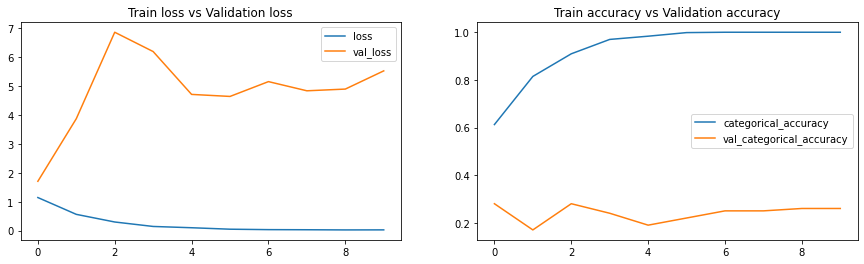

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.2800000011920929


In [17]:
plotModelHistory(model1_history)

### Model 2 - Conv3D + MaxPooling3D, Increased Batch size and with Dropouts

663 100 32 21 4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 128, 128, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 15, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 32, 32, 32)   0         
 3D)                                                             
                                      

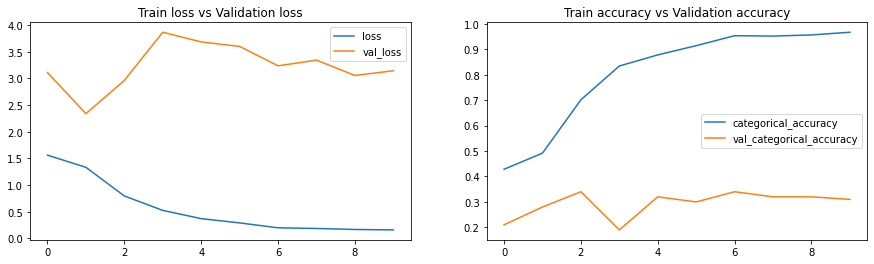

Max. Training Accuracy 0.9668174982070923
Max. Validaiton Accuracy 0.3400000035762787


In [18]:
# Defining few parameters
batch_size = 32
n_frames = 30
num_epochs = 10

# Creating train and validation data generators
train_generator = generator(train_path, train_doc, batch_size, n_frames=n_frames)
val_generator = generator(val_path, val_doc, batch_size, n_frames=n_frames)

# Creating list of call backs 
model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# Deriving steps_per_epoch and validation_steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print(num_train_sequences, num_val_sequences,batch_size, steps_per_epoch,validation_steps )
    
# Defining a model
model2 = Sequential([
    Conv3D(16, (3, 3, 3), activation='relu', padding="same", input_shape=(n_frames, 128, 128, 3)),
    MaxPooling3D((2, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(32, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
])

# Compiling the model
optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

# Fitting the model
model2_history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plotting model loass and accuracy
plotModelHistory(model2_history)

### Model 3 - Conv3D with increased filter size

663 100 64 11 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 128, 128, 16)  6016      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 10, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 32, 32, 32)   0         
 3D)                                                             
                                      

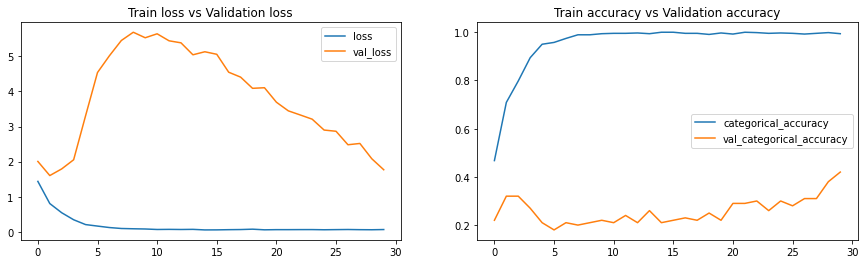

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.41999998688697815


In [19]:
# Defining few parameters
batch_size = 64
n_frames = 20
num_epochs = 30

# Creating train and validation data generators
train_generator = generator(train_path, train_doc, batch_size, n_frames=n_frames)
val_generator = generator(val_path, val_doc, batch_size, n_frames=n_frames)

# Creating list of call backs 
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# Deriving steps_per_epoch and validation_steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print(num_train_sequences, num_val_sequences,batch_size, steps_per_epoch,validation_steps )
    
# Defining a model
model3 = Sequential([
    Conv3D(16, (5, 5, 5), activation='relu', padding="same", input_shape=(n_frames, 128, 128, 3)),
    MaxPooling3D((2, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(32, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu', padding="same"),
    MaxPooling3D((1, 2, 2), padding="same"),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
])

# Compiling the model
optimiser = optimizers.Adam()
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

# Fitting the model
model3_history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plotting model loass and accuracy
plotModelHistory(model3_history)

### Model 4 - Conv2D + GRU

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed

663 100 64 11 2


2023-02-15 12:33:21.323336: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-15 12:33:21.323408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (64, 20, 128, 128, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (64, 20, 64, 64, 16)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (64, 20, 64, 64, 16)     64        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (64, 20, 64, 64, 32)     4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (64, 20, 32, 32, 32)     0

2023-02-15 12:33:34.682909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.5536 - categorical_accuracy: 0.3514Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 2.45917, saving model to model4_init_2023-02-1512_31_47.743053/model4-00001-1.55359-0.35143-2.45917-0.18000.h5
11/11 [==============================] - 117s 11s/step - loss: 1.5536 - categorical_accuracy: 0.3514 - val_loss: 2.4592 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.0244 - categorical_accuracy: 0.6063
Epoch 00002: val_loss did not improve from 2.45917
11/11 [==============================] - 109s 11s/step - loss: 1.0244 - categorical_accuracy: 0.6063 - val_loss: 2.8250 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.7685 - categorical_accuracy: 0.7104
Epoch 00003: val_loss did not improve from 2.45917
11/11 [=============================

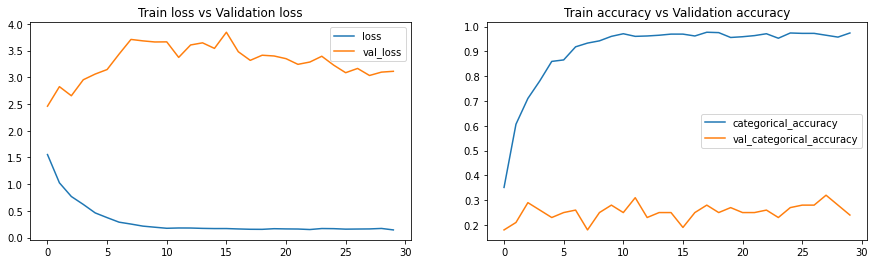

Max. Training Accuracy 0.9773755669593811
Max. Validaiton Accuracy 0.3199999928474426


In [21]:
# Defining few parameters
batch_size = 64
n_frames = 20
num_epochs = 30

# Creating train and validation data generators
train_generator = generator(train_path, train_doc, batch_size, n_frames=n_frames)
val_generator = generator(val_path, val_doc, batch_size, n_frames=n_frames)

# Creating list of call backs 
model_name = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model4-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# Deriving steps_per_epoch and validation_steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print(num_train_sequences, num_val_sequences,batch_size, steps_per_epoch,validation_steps )
    
# Defining a model
model4 = Sequential([
    TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding="same")),
    TimeDistributed(MaxPooling2D((2, 2), padding="same")),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding="same")),
    TimeDistributed(MaxPooling2D((2, 2), padding="same")),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding="same")),
    TimeDistributed(MaxPooling2D((2, 2), padding="same")),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Flatten()),
    GRU(128),
    Dropout(0.25),
    
    Dense(128, activation='relu'),
    ##BatchNormalization(),
    Dropout(0.25),

    #Dense(64, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.25),

    Dense(5, activation='softmax')
])

# Compiling the model
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model4.build(input_shape=(batch_size, n_frames, 128, 128, 3))
print (model4.summary())

# Fitting the model
model4_history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plotting model loass and accuracy
plotModelHistory(model4_history)

### Model 5 - Transfer Learning (MobileNet) + GRU

In [22]:
from tensorflow.keras.applications import mobilenet

663 100 64 11 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 20, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 20, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 4096)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 25

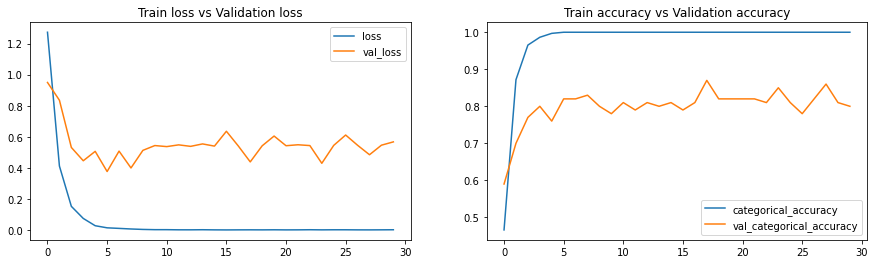

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8700000047683716


In [23]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

# Defining few parameters
batch_size = 64
n_frames = 20
num_epochs = 30

# Creating train and validation data generators
train_generator = generator(train_path, train_doc, batch_size, n_frames=n_frames)
val_generator = generator(val_path, val_doc, batch_size, n_frames=n_frames)

# Creating list of call backs 
model_name = 'model5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model5-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# Deriving steps_per_epoch and validation_steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print(num_train_sequences, num_val_sequences,batch_size, steps_per_epoch,validation_steps )
    
# Defining a model
model5 = Sequential([
    TimeDistributed(mobilenet, input_shape=(n_frames, 128, 128, 3))

])
for layer in model5.layers:
    layer.trainable = False
    
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Flatten()))

model5.add(GRU(256))
model5.add(Dropout(0.25))

model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))

# Compiling the model
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

# Fitting the model
model5_history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plotting model loass and accuracy
plotModelHistory(model5_history)

### Model 6 - Transfer Learning (MobileNet) + LSTM

In [24]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.applications import mobilenet

663 100 64 11 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 20, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 4096)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 25

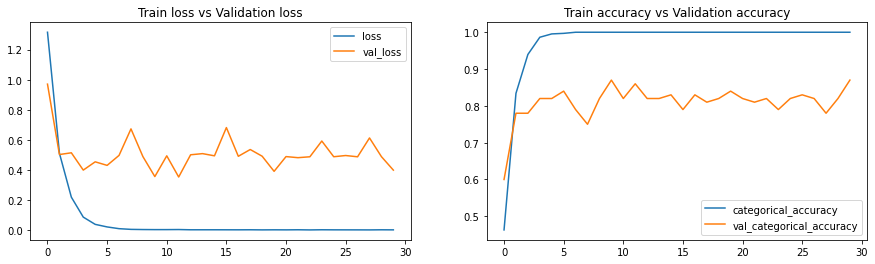

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8700000047683716


In [25]:

mobilenet = mobilenet.MobileNet(weights = 'imagenet', include_top = False)

# Defining few parameters
batch_size = 64
n_frames = 20
num_epochs = 30

# Creating train and validation data generators
train_generator = generator(train_path, train_doc, batch_size, n_frames=n_frames)
val_generator = generator(val_path, val_doc, batch_size, n_frames=n_frames)

# Creating list of call backs 
model_name = 'model6_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model6-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto')

LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# Deriving steps_per_epoch and validation_steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print(num_train_sequences, num_val_sequences,batch_size, steps_per_epoch,validation_steps )
    
# Defining a model
model6 = Sequential([
    TimeDistributed(mobilenet, input_shape = (n_frames, 128, 128, 3))

])
for layer in model6.layers:
    layer.trainable = False
    
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Flatten()))

model6.add(LSTM(256))
model6.add(Dropout(0.25))

model6.add(Dense(256,activation = 'relu'))
model6.add(Dropout(0.25))

model6.add(Dense(5, activation = 'softmax'))

# Compiling the model
optimiser = optimizers.Adam()
model6.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print (model6.summary())

# Fitting the model
model6_history = model6.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = num_epochs, verbose = 1, 
                   callbacks = callbacks_list, validation_data = val_generator, 
                   validation_steps = validation_steps, class_weight = None, workers = 1, initial_epoch = 0)

# Plotting model loass and accuracy
plotModelHistory(model6_history)